In [79]:
import numpy as np
from lab2_tools import *
from lab2_proto import *
from tqdm import tqdm
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 4)

Populating the interactive namespace from numpy and matplotlib


In [80]:
# Load example data
example = load('lab2_example.npz',allow_pickle=True)['example'].item()
samplingrate_ex = example['samplingrate']
gender_ex = example['gender']
speaker_ex = example['speaker']
digit_ex = example['digit']
repetition_ex = example['repetition']
samples_ex = example['samples']
lmfcc_ex = example['lmfcc']

obsloglik_ex = example['obsloglik']
logalpha_ex = example['logalpha']
loglik_ex = example['loglik']
vloglik_ex = example['vloglik']
vpath_ex = example['vpath']
logbeta_ex = example['logbeta']
loggamma_ex = example['loggamma']

# Load all data(44 uterances z-10 2male and 2female)
data = np.load('lab2_data.npz',allow_pickle=True)['data']
print("data of length:",len(data) )
print(data[1].keys())
print("============")

# Load parameters
phoneHMMs_all = np.load('lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_one = load('lab2_models_onespkr.npz',allow_pickle=True)['phoneHMMs'].item()
print("phoneme HMM models:")
print(list(sorted(phoneHMMs_one.keys())))
print(phoneHMMs_one['sp'].keys())


data of length: 44
dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc'])
phoneme HMM models:
['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])


# 4) Concatinating HMMs

In [81]:
hmm1 = phoneHMMs_one['f']
hmm2 = phoneHMMs_one['sp']
print(hmm1['transmat'])
print()
print(hmm2['transmat'])
print()
print()
print(hmm1['startprob'])
print(hmm2['startprob'])
print("\n==========================================================")
print("==========================================================\n")
twoHMms=concatTwoHMMs(hmm1, hmm2)
print(twoHMms['startprob'])
print()
print(twoHMms['transmat'])

[[0.8437548 0.1562452 0.        0.       ]
 [0.        0.7090222 0.2909778 0.       ]
 [0.        0.        0.3064214 0.6935785]
 [0.        0.        0.        1.       ]]

[[0.8144019 0.1855981]
 [0.        1.       ]]


[1. 0. 0. 0.]
[0.2403483 0.7596517]


[1. 0. 0. 0. 0.]

[[0.8437548  0.1562452  0.         0.         0.        ]
 [0.         0.7090222  0.2909778  0.         0.        ]
 [0.         0.         0.3064214  0.16670041 0.52687809]
 [0.         0.         0.         0.8144019  0.1855981 ]
 [0.         0.         0.         0.         1.        ]]


### Add silence in begining and end of each utterance(word)

In [82]:
from prondict import *
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
print(isolated)


{'o': ['sil', 'ow', 'sil'], 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'], '1': ['sil', 'w', 'ah', 'n', 'sil'], '2': ['sil', 't', 'uw', 'sil'], '3': ['sil', 'th', 'r', 'iy', 'sil'], '4': ['sil', 'f', 'ao', 'r', 'sil'], '5': ['sil', 'f', 'ay', 'v', 'sil'], '6': ['sil', 's', 'ih', 'k', 's', 'sil'], '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'], '8': ['sil', 'ey', 't', 'sil'], '9': ['sil', 'n', 'ay', 'n', 'sil']}


### Build HMM models for each utterance(word) in prondict

In [83]:
wordHMMs = {}
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs_one, isolated[uterance])


# 5) HMM Likelihood and Recognition

## Observation log likelihood of an utterance
Observation log likelihood is the likelihood of each frame of the recorded utterance for every gaussian model of each possible state of the considered HMM model.

In [84]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])


Same results for obsloglik f 'o' as in example: True


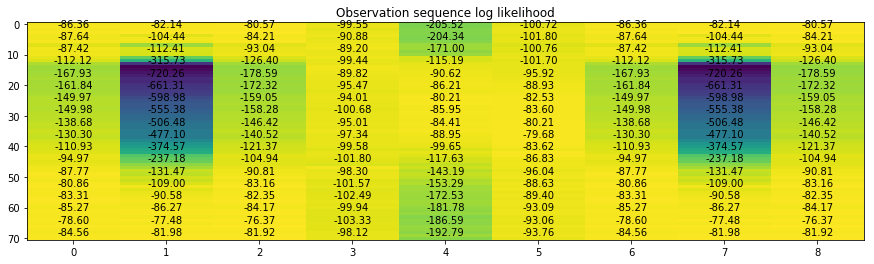

(71, 9)

In [85]:
from matplotlib import pyplot as plt

# plt.imshow(obsloglik_ex, interpolation='nearest', aspect='auto')
# plt.show()
print("Same results for obsloglik f 'o' as in example:", np.allclose(obsloglik_ex, obsloglik))
plt.imshow(obsloglik, interpolation='nearest', aspect='auto')
for (i, j), z in np.ndenumerate(obsloglik):
    if np.mod(i,4)==0 and np.mod(j,1)==0:
        plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center')
plt.title("Observation sequence log likelihood")
plt.show()
obsloglik_ex.shape

From the pattern shown in the plot above we can clearly see that steps 1-10 and 45-71 correspond to sil, the rest of the steps in the middle correspond to 'ow'.
It looks like the observations(steps) during 'ow' have small likelihoods for the 1'st and 7'th gaussian whereas 'sil' is more equally distributed. In addition to that we observe that 'sil' tends to have low likelihood values for the 4th gaussian. 

The low likelihood values are shown in blue in the figure above
(the smaller the value --> the more negative --> the darker).

## a) Forward Algorithm

The **Forward algorithm** is an algorithm that helps computing the forward probabilities in a recursive manner.\
The forward probability is defined $P(O_{0:n}, z_n=s_i)$ as the joint probability of the observations up to step n and $n_{th}$ hidden state corresponding to state $s_i$.\
In order to find find the likelihood of the observation sequence one marganilizes the hidden state, i.e. $\sum_{i}{P(O_{0:N}, z_N=s_i)}$. 

When working with logarithms multiplications are transformed to summations and summations to logsumexp().

In [86]:
def forward(log_emlik, log_startprob, log_transmat, obs_log_ll = False ):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states  log P(Oi|Xi)
        log_startprob: log probability to start in state i                    log P(Xi)
        log_transmat: log transition probability from state i to j            log P(Xj|Xi)
        obs_log_ll: True if we want the function to return both the alpha matrix and the log likelihood of seq.
    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    
    log_startprob = log_startprob[:-1]
    log_transmat = log_transmat[:-1,:-1]
    
    N, M = log_emlik.shape 
    forward_prob = np.zeros((N, M))                    # [N X M]      P(O1:)

    forward_prob[0,:] = log_startprob + log_emlik[0, :]

    for n in range(1,N):
        for i in range(M):
            forward_prob[n,i] = logsumexp(forward_prob[n-1,:]+log_transmat[:,i] ) + log_emlik[n,i]
    
    if obs_log_ll:
        return forward_prob,  logsumexp(forward_prob[-1,:])  
    
    return forward_prob

### Correctness of implementation

Observation sequence has the log likelihood:  -5970.427602563561
Forward pass is implemented correctly: True
Loglikelihood do observation sequence found correctly: True


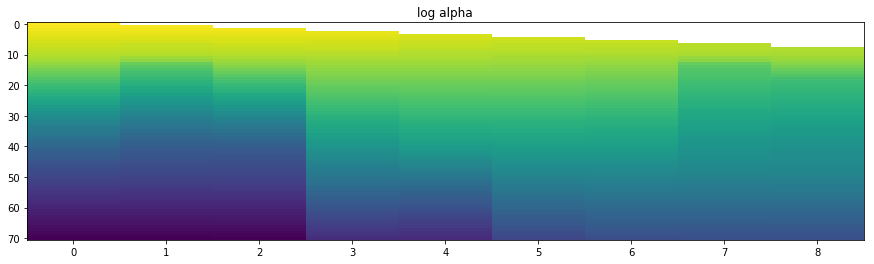

In [87]:
import warnings
warnings.filterwarnings('ignore')

log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])

logalpha,obs_seq_log_likelihood = forward(obsloglik, log_startprob, log_transmat,True)
# obs_seq_log_likelihood = np.log(np.sum(np.exp(logalpha[-1,:],dtype =np.float128)))

print("Observation sequence has the log likelihood: ", obs_seq_log_likelihood)
print("Forward pass is implemented correctly:",np.allclose(logalpha_ex, logalpha))
print("Loglikelihood do observation sequence found correctly:",np.allclose(loglik_ex, obs_seq_log_likelihood))
plt.imshow(logalpha, interpolation='nearest', aspect='auto')
plt.title("log alpha")
plt.show()


### Max likelihood on the 44 utterances

In [88]:
max_likelihoods = []

# variables to save best mode at the moment and the max loglikelihood it gives the given sequence
max_ll= -inf
max_ll_model =""


for sample in tqdm(data):
    digit = sample['digit']
    # reset max_ll and dic
    max_ll= -inf
    dic = {}
    for hmm_model in wordHMMs:
        # logll of digit's each lmfcc on each state of hmm_model
        obs_ll= log_multivariate_normal_density_diag(sample['lmfcc'], 
                                                     wordHMMs[hmm_model]['means'], 
                                                     wordHMMs[hmm_model]['covars'])
        
        log_startprob_tmp = np.log(wordHMMs[hmm_model]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm_model]['transmat'])
        
        # logll of digit's lmfcc(all frames considered) on hmm_model
        _,obs_seq_log_likelihood = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True) 

        if obs_seq_log_likelihood > max_ll:
            max_ll = obs_seq_log_likelihood
            max_ll_model = hmm_model
            
    dic[digit + '_' + sample['gender']] = max_ll_model
    dic['max_ll'] = max_ll
    
    max_likelihoods.append(dic)    

100%|██████████| 44/44 [00:25<00:00,  1.73it/s]


In [89]:
print(1-10/22)
max_likelihoods

0.5454545454545454


[{'o_man': 'o', 'max_ll': -6755.29295367825},
 {'o_man': 'o', 'max_ll': -6097.0523998906965},
 {'z_man': 'z', 'max_ll': -8118.200380361543},
 {'z_man': 'z', 'max_ll': -7687.5887955841135},
 {'1_man': '3', 'max_ll': -6997.069086161187},
 {'1_man': '9', 'max_ll': -7198.409743244815},
 {'2_man': '3', 'max_ll': -6227.59482796606},
 {'2_man': '2', 'max_ll': -7520.048008578062},
 {'3_man': '3', 'max_ll': -7245.060397819047},
 {'3_man': '3', 'max_ll': -8101.060919329966},
 {'4_man': '4', 'max_ll': -7227.865033718987},
 {'4_man': '4', 'max_ll': -7191.665977473049},
 {'5_man': '3', 'max_ll': -7699.838609516217},
 {'5_man': '3', 'max_ll': -7053.1633404817685},
 {'6_man': '6', 'max_ll': -8062.449795380257},
 {'6_man': '6', 'max_ll': -8412.751985655648},
 {'7_man': '3', 'max_ll': -7739.72902402962},
 {'7_man': '3', 'max_ll': -7918.755244419525},
 {'8_man': '3', 'max_ll': -6418.780042488298},
 {'8_man': '3', 'max_ll': -6649.444068829668},
 {'9_man': '9', 'max_ll': -9349.992707960357},
 {'9_man': 'z

As we observe from the results above all utterances pronaunced by women are recognized correctly.
The men pronaunced utterances lead to a recognition accuracy of only $54.54\%$. We notice in addition that most of the misrecognised utterances are recognized as '3'.

## b) Viterbi Approximation

$V_n(i) = max_{q_{0:t-1}}  P(O_{0:n}, q_t)$

In [90]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path(decoding).

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    log_startprob = log_startprob[:-1]
    log_transmat = log_transmat[:-1,:-1]

    N, M = log_emlik.shape
    V = np.zeros((N,M)) # Viterbi loglikelihoods
    V_path = np.zeros((N,M),dtype=np.int64) # Viterbi indexes
    
    viterbi_path = np.zeros(N,dtype=np.int64)
    
    
    V[0,:] = log_startprob + log_emlik[0,:]
    for n in range(1,N):
        for i in range(M):
            # highest log likelihood to come to state i in time n
            V[n,i] = np.max(V[n-1,:]+log_transmat[:,i] + log_emlik[n,i])
            # best previous state in time n-1 that brought us to state i in time n
            V_path[n,i] = np.argmax(V[n-1,:]+log_transmat[:,i] + log_emlik[n,i])
    
    # path backtracking 
    viterbi_path[-1] = np.argmax(V[-1,:])
    for i in range(V_path.shape[0]-2,0,-1):
        viterbi_path[i] = V_path[i+1,viterbi_path[i+1]]

    
    return np.max(V[-1,:]), viterbi_path

True
True


[]

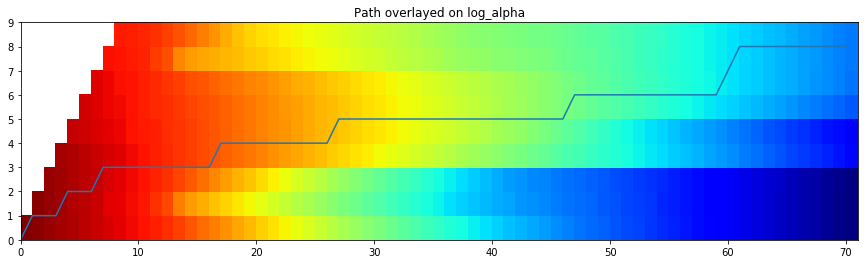

In [91]:
viterbi_loglik, viterbi_path = viterbi(obsloglik, log_startprob, log_transmat)
print(np.allclose(viterbi_path, vpath_ex))
print(np.allclose(viterbi_loglik, vloglik_ex))

plt.pcolormesh(np.ma.masked_invalid(logalpha).T, cmap='jet')
plt.plot( np.arange(len(viterbi_path)),viterbi_path)
plt.title("Path overlayed on log_alpha")
plt.plot()

### Viterbi Algorithm used for max_ll recognition 
As we see below the recognition using Viterbi and forward algo are not identical. While Forward path consideres all possible paths and marginalized ober them, Viterbi considers only the best path and returns its log likelihood.
But using Viterbi to calculate the likelihood is much less computational heavy(3.54it/s instead of 1.64it/s for the forward algo) and that is why it is normally the prefered inference method when dealing with very long seqeuences from which too many possible paths can be built .

The main reason forthis is that Viterbi calculates the log likelihood only for the best path instead of all possible paths as the forward path does.

In [92]:
max_likelihoods = []

# variables to save best mode at the moment and the max loglikelihood it gives the given sequence
max_ll= -inf
max_ll_model =""


for sample in tqdm(data):
    digit = sample['digit']
    # reset max_ll and dic
    max_ll= -inf
    dic = {}
    for hmm_model in wordHMMs:
        # logll of digit's each lmfcc on each state of hmm_model
        obs_ll= log_multivariate_normal_density_diag(sample['lmfcc'], 
                                                     wordHMMs[hmm_model]['means'], 
                                                     wordHMMs[hmm_model]['covars'])
        
        log_startprob_tmp = np.log(wordHMMs[hmm_model]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm_model]['transmat'])
        
        # logll of digit's lmfcc(all frames considered) on hmm_model
        obs_seq_log_likelihood, _ = viterbi(obs_ll, log_startprob_tmp, log_transmat_tmp)
        
        if obs_seq_log_likelihood > max_ll:
            max_ll = obs_seq_log_likelihood
            max_ll_model = hmm_model
            
    dic[digit + '_' + sample['gender']] = max_ll_model
    dic['max_ll'] = max_ll
    
    max_likelihoods.append(dic)    

100%|██████████| 44/44 [00:13<00:00,  3.33it/s]


In [93]:
max_likelihoods

[{'o_man': 'o', 'max_ll': -6757.997215470573},
 {'o_man': 'o', 'max_ll': -6100.253650325265},
 {'z_man': 'z', 'max_ll': -8120.4084077033895},
 {'z_man': 'z', 'max_ll': -7690.9047105911595},
 {'1_man': '3', 'max_ll': -6998.301610596523},
 {'1_man': '9', 'max_ll': -7200.652138504673},
 {'2_man': '3', 'max_ll': -6229.627725505495},
 {'2_man': '2', 'max_ll': -7521.991523893783},
 {'3_man': '3', 'max_ll': -7247.062024450119},
 {'3_man': '3', 'max_ll': -8104.036978231511},
 {'4_man': '4', 'max_ll': -7231.055218794898},
 {'4_man': '4', 'max_ll': -7193.8492178670895},
 {'5_man': '3', 'max_ll': -7700.915074464565},
 {'5_man': '3', 'max_ll': -7054.538626004525},
 {'6_man': '6', 'max_ll': -8065.726815463304},
 {'6_man': '6', 'max_ll': -8415.276197995192},
 {'7_man': '3', 'max_ll': -7741.489436564968},
 {'7_man': '3', 'max_ll': -7920.664131255515},
 {'8_man': '3', 'max_ll': -6421.700940335606},
 {'8_man': '3', 'max_ll': -6651.482990476667},
 {'9_man': '9', 'max_ll': -9351.221810988502},
 {'9_man':

## c) Backward Algorithm

In [94]:
def backward(log_emlik, log_startprob, log_transmat, loglik = False):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """
    log_startprob = log_startprob[:-1]
    log_transmat = log_transmat[:-1,:-1]

    N, M = log_emlik.shape
    backward_prob = np.zeros((N,M))
    #backward_prob[-1,:] = 1
    for n in range(N-2,-1,-1):
        for i in range(M): 
            backward_prob[n,i] = logsumexp(backward_prob[n+1,:] + log_transmat[i,:] + log_emlik[n+1,:])
    if loglik:
        obs_seq_log_lik = logsumexp(backward_prob[0,:] + log_startprob + obsloglik[0,:])
        return backward_prob, obs_seq_log_lik
    return backward_prob   

In [95]:
backward_prob, loglik = backward(obsloglik, log_startprob, log_transmat,True)
print("*Backward algorithm is implemented correctly:",np.allclose(backward_prob, logbeta_ex))
print("*The log likelihood from the backward probabilities(Beta matrix) is calculated correctly:", np.allclose(loglik_ex, loglik))


*Backward algorithm is implemented correctly: True
*The log likelihood from the backward probabilities(Beta matrix) is calculated correctly: True


# 6) HMM Retraining

$\gamma_n(i)= P(z_n = s_i|X,\theta)$ where $X$ is the observations sequence and $z_n$ the $n_{th}$ hidden state. As we show below if we sum over $i$ we should get 1, this correspond to summing the colums of the exponential of log_gamma. We show below that this holds.

In [96]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    return log_alpha + log_beta - logsumexp(log_alpha[-1,:])



State posteriors are computed correctly for the example True
Sums of all rows over the colums of log_gama are all 1: True


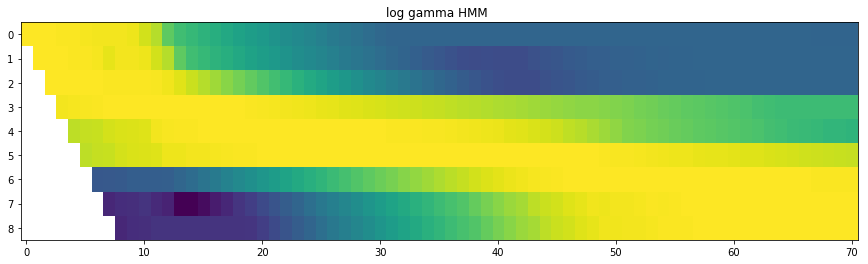

In [97]:
X = example['lmfcc']

# Prerequisite for log_gamma
hmm_model = wordHMMs['o']
obs_ll= log_multivariate_normal_density_diag(X, hmm_model['means'],hmm_model['covars'])
log_startprob_tmp = np.log(hmm_model['startprob'])
log_transmat_tmp = np.log(hmm_model['transmat'])
log_alpha, ll_ = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True)
log_beta = backward(obs_ll, log_startprob_tmp, log_transmat_tmp)



# Calculate log_gamma
log_gamma = statePosteriors(log_alpha, log_beta)

print("State posteriors are computed correctly for the example", np.allclose(loggamma_ex, log_gamma))
print("Sums of all rows over the colums of log_gama are all 1:", np.allclose(np.sum(np.exp(log_gamma),1),1.0))

plt.imshow(log_gamma.T, interpolation='nearest', aspect='auto')
plt.title("log gamma HMM ")
plt.show()

In [98]:
def gmmloglik(log_emlik, weights):
    """Log Likelihood for a GMM model based on Multivariate Normal Distribution.

    Args:
        log_emlik: array like, shape (N, K).
            contains the log likelihoods for each of N observations and
            each of K distributions
        weights:   weight vector for the K components in the mixture

    Output:
        gmmloglik: scalar, log likelihood of data given the GMM model.
    """

$\gamma^{GMM}_n(i)= P(z_n = s_i|x_n,\phi)$ is the state posterior using the GMM model.

The main difference between the GMM state posteriors and the HMM state posteriors is that for the GMM the observed frames are considered seperately to calculate the posterior whereas for the state posteriors of the HMM the whole observation sequence(all frames) are considered. That is the reason too, why we excpect that HMM will deliver better state posteriors for a given observation sequence.

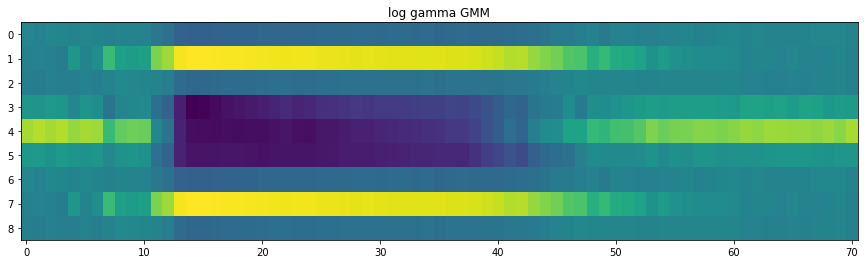

In [99]:
X = example['lmfcc']

# First iteration
hmm_model = wordHMMs['o']
# obs_ll is [N,M] where N are the time steps and M the hidden states of the HMM
obs_ll= log_multivariate_normal_density_diag(X, hmm_model['means'],hmm_model['covars'])

gamma_gmm = obs_ll/obs_ll.sum(1)[:,np.newaxis]

plt.imshow(np.log(gamma_gmm).T, interpolation='nearest', aspect='auto')
#plt.imshow(gamma_gmm.T, interpolation='nearest', aspect='auto')
plt.title("log gamma GMM")
plt.show()

## Training

In [100]:
def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """
    D = X.shape[1]
    N, M = log_gamma.shape
    means = np.zeros((M, D))
    covars = np.zeros((M, D))
    
    gamma = np.exp(log_gamma)

    means = gamma.T[:,:,np.newaxis]*X[np.newaxis,:,:] # NxMxD
    means = means .sum(1)
    means = means/ gamma.sum(0).T[:,np.newaxis]
    
    X_mu = X[:,np.newaxis,:]-means[np.newaxis,:,:]# NxMxD
    X_mu_2 = X_mu *X_mu
    covars = (X_mu_2*gamma[:,:,np.newaxis]).sum(0)/ gamma.sum(0).T[:,np.newaxis]
    covars[covars < varianceFloor] = varianceFloor
    return means,covars



### Training of HMM  for uterance '4' starting for HMM model for '4'
As we observe below the convergence occures in only 13 iterations.

In [101]:
X = data[10]['lmfcc']

# First iteration
hmm_model = wordHMMs['4']
obs_ll= log_multivariate_normal_density_diag(X, 
                                             hmm_model['means'], 
                                             hmm_model['covars'])
log_startprob_tmp = np.log(hmm_model['startprob'])
log_transmat_tmp = np.log(hmm_model['transmat'])
log_alpha, ll_ = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True)
log_beta = backward(obs_ll, log_startprob_tmp, log_transmat_tmp)
log_gamma = statePosteriors(log_alpha, log_beta)

means,covars = updateMeanAndVar(X, log_gamma)

ll = 0
for i in range(1,20):
    obs_ll= log_multivariate_normal_density_diag(X, means, covars)

    print("iteration "+str(i)+":",ll_)
    if np.allclose(ll, ll_):
        print("CONVERGED!")
        break
    ll = ll_
    # expectation
    log_alpha, ll_ = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True)
    log_beta = backward(obs_ll, log_startprob_tmp, log_transmat_tmp)
    log_gamma = statePosteriors(log_alpha, log_beta)
    
    # maximization
    means,covars = updateMeanAndVar(X, log_gamma,1)


iteration 1: -7227.865033718987
iteration 2: -6438.012326767756
iteration 3: -6115.4226248548985
iteration 4: -6019.760911159053
iteration 5: -5962.906021818365
iteration 6: -5935.888680743657
iteration 7: -5916.958837788634
iteration 8: -5912.712690482596
iteration 9: -5903.190104657994
iteration 10: -5901.98328508341
iteration 11: -5900.771538162837
iteration 12: -5900.392617528682
iteration 13: -5900.390225751181
CONVERGED!


### Training of HMM  for uterance '4' starting for HMM model for '1'

In [102]:
X = data[10]['lmfcc']

# First iteration
hmm_model = wordHMMs['1']
obs_ll= log_multivariate_normal_density_diag(X, 
                                             hmm_model['means'], 
                                             hmm_model['covars'])
log_startprob_tmp = np.log(hmm_model['startprob'])
log_transmat_tmp = np.log(hmm_model['transmat'])
log_alpha, ll_ = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True)
log_beta = backward(obs_ll, log_startprob_tmp, log_transmat_tmp)
log_gamma = statePosteriors(log_alpha, log_beta)

means,covars = updateMeanAndVar(X, log_gamma)

ll = 0
for i in range(1,20):
    obs_ll= log_multivariate_normal_density_diag(X, means, covars)

    print("iteration "+str(i)+":",ll_)
    if np.allclose(ll, ll_):
        print("CONVERGED!")
        break
    ll = ll_
    # expectation
    log_alpha, ll_ = forward(obs_ll, log_startprob_tmp, log_transmat_tmp,True)
    log_beta = backward(obs_ll, log_startprob_tmp, log_transmat_tmp)
    log_gamma = statePosteriors(log_alpha, log_beta)
    
    # maximization
    means,covars = updateMeanAndVar(X, log_gamma,1)


iteration 1: -7565.191151286106
iteration 2: -6232.208306466498
iteration 3: -6034.418894541493
iteration 4: -6022.378395517052
iteration 5: -6015.23666765336
iteration 6: -6012.168799391056
iteration 7: -5998.367904330801
iteration 8: -5988.532386195701
iteration 9: -5983.966068276879
iteration 10: -5981.507132336638
iteration 11: -5981.358637263235
iteration 12: -5978.83920006543
iteration 13: -5958.2805382200595
iteration 14: -5947.463460637393
iteration 15: -5935.985654009085
iteration 16: -5934.722136761179
iteration 17: -5934.7169930779
CONVERGED!
